In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\lolen\Downloads\Jupyter Mac\Python\5-Projects\LSTM,RNN,CNN\Time-Series-Forecasting-LSTM-main\monthly_milk_production.csv",index_col='Date',parse_dates=True)
df.index.freq='MS'

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

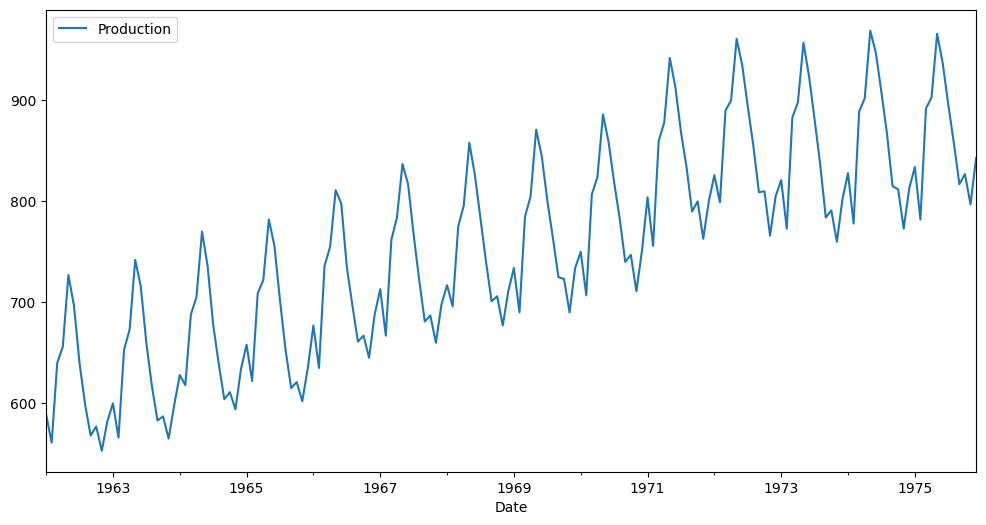

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

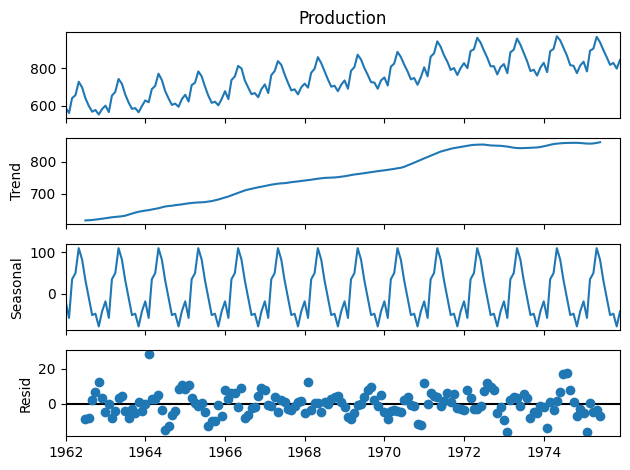

In [6]:
results = seasonal_decompose(df['Production'])
results.plot();

In [7]:
len(df)

168

In [8]:
train = df.iloc[:156]
test = df.iloc[156:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [30]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, n_input):
        self.data = data
        self.n_input = n_input

    def __len__(self):
        return len(self.data) - self.n_input

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.n_input]
        y = self.data[idx+self.n_input]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



# Create the dataset and data loader
n_input = 12
dataset = TimeSeriesDataset(scaled_train, n_input)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [32]:
scaled_train.shape

(156, 1)

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features, hidden_dim=100, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(n_features, hidden_dim, batch_first=True)
        self.lstm = nn.LSTM(n_features, hidden_dim, batch_first=True)
        self.lstm = nn.LSTM(n_features, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  
        out = self.relu(lstm_out)
        out = self.fc(out)
        return out

n_features = 1  # Number of features
hidden_dim = 100
output_dim = 1

model = LSTMModel(n_input, n_features, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
model.train()
for epoch in range(num_epochs):
    for inputs, targets in data_loader:
        # Ensure inputs have the shape (batch_size, sequence_length, num_features)
        inputs = inputs.view(1, n_input, n_features)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


cuda
Epoch 1/200, Loss: 0.00856786035001278
Epoch 2/200, Loss: 0.0033830231986939907
Epoch 3/200, Loss: 0.02132587693631649
Epoch 4/200, Loss: 0.008471674285829067
Epoch 5/200, Loss: 0.004872011486440897
Epoch 6/200, Loss: 0.003808907698839903
Epoch 7/200, Loss: 0.025440212339162827
Epoch 8/200, Loss: 0.013416838832199574
Epoch 9/200, Loss: 0.0019074956653639674
Epoch 10/200, Loss: 0.015537576749920845
Epoch 11/200, Loss: 0.0024359424132853746
Epoch 12/200, Loss: 0.0026149225886911154
Epoch 13/200, Loss: 0.0034886091016232967
Epoch 14/200, Loss: 0.011210755445063114
Epoch 15/200, Loss: 0.004824667237699032
Epoch 16/200, Loss: 0.0064181252382695675
Epoch 17/200, Loss: 9.142530325334519e-05
Epoch 18/200, Loss: 0.00020173740631435066
Epoch 19/200, Loss: 0.0005608525825664401
Epoch 20/200, Loss: 0.009714221581816673
Epoch 21/200, Loss: 0.003111510770395398
Epoch 22/200, Loss: 0.0013243008870631456
Epoch 23/200, Loss: 0.0014955351362004876
Epoch 24/200, Loss: 4.233418803778477e-05
Epoch 25/

In [74]:
last_train_batch = scaled_train[-12:]

In [75]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [76]:
last_train_batch.shape

(1, 12, 1)

In [77]:
last_train_batch = torch.tensor(last_train_batch, dtype=torch.float32).view(1, n_input, n_features)

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    prediction = model(last_train_batch)

# Print the prediction
print(prediction)

tensor([[0.6575]])


In [78]:
scaled_test[0]

array([0.67548077])

In [79]:
import torch
import numpy as np

# Initialize the list for storing predictions
test_predictions = []

# Prepare the first evaluation batch
first_eval_batch = scaled_train[-n_input:]
current_batch = torch.tensor(first_eval_batch, dtype=torch.float32).view(1, n_input, n_features)

# Set the model to evaluation mode
model.eval()

# Loop to generate predictions for the test set
for i in range(len(test)):
    # Disable gradient calculations
    with torch.no_grad():
        # Get the prediction for the current batch
        current_pred = model(current_batch)[0]
    
    # Append the prediction to the test_predictions list
    test_predictions.append(current_pred.item())
    
    # Update the current batch by removing the first time step and adding the prediction at the end
    current_batch = torch.cat((current_batch[:, 1:, :], current_pred.view(1, 1, 1)), dim=1)

# Convert the predictions to a NumPy array if needed
test_predictions = np.array(test_predictions)


In [80]:
test_predictions

array([0.65750986, 0.5711031 , 0.80917639, 0.85502112, 0.98557115,
       0.94504166, 0.85785782, 0.76664031, 0.62542343, 0.60007238,
       0.50834584, 0.61623722])

In [81]:
current_batch[0][0]

tensor([0.6575])

In [82]:
test_predictions

array([0.65750986, 0.5711031 , 0.80917639, 0.85502112, 0.98557115,
       0.94504166, 0.85785782, 0.76664031, 0.62542343, 0.60007238,
       0.50834584, 0.61623722])

In [83]:
test_predictions = test_predictions.reshape(-1, 1)

In [63]:
test_predictions

array([[0.54137075],
       [0.54760748],
       [0.69548035],
       [0.78414035],
       [0.8687067 ],
       [0.85980034],
       [0.79641855],
       [0.69576722],
       [0.58463925],
       [0.52490282],
       [0.47829819],
       [0.48020604]])

In [84]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,778.210232
1975-02-01,782,780.804712
1975-03-01,892,842.319824
1975-04-01,903,879.202385
1975-05-01,966,914.381989


In [85]:
true_predictions = scaler.inverse_transform(test_predictions)

In [86]:
test['Predictions'] = true_predictions

C:\Users\lolen\AppData\Local\Temp\ipykernel_24040\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

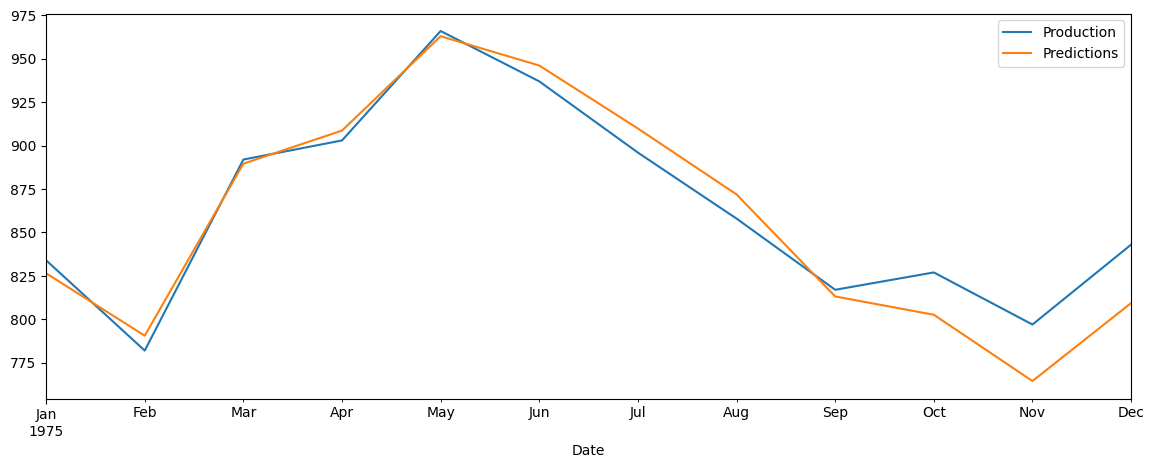

In [87]:
test.plot(figsize=(14,5))

In [88]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

16.94306131126902
